### Mission Statement
* In this simulation, a popular YouTuber has asked to analyze the comment section from one of his recent videos
* Asks:
    * What are the broad things people talking about?
    * He has ads in the video. Are people talking about his ads?
    * Anything else useful we might find

General Directions from the YouTuber:
* We want the number of likes on a comment to inform the process somehow. Likes is big part of engagement.
* There are obviously lots and lots of things in the comments section, but we are to somehow make sense of them and report back

### General Process
* Pull the data from Youtube
    * Get all comments and the number of likes for each comment
* Clean the data
    * Remove any duplicates
        * The pinned comment is the only a true duplicate
        * If the same comment is posted by different users, combine it into one comment with the total number of likes
    * Translate all comments to English
    * We can assume any comments with zero likes is just noise
* Get text embedding of each unique comment
* Perform dimensionality reduction
    * Clustering algorithms generally perform better in relatively low dimensional space
* Cluster the comments
    * Use a weighted clustering clustering algorithm with the number of likes acting as the sample weight
* Perform topicl modeling (TF-IDF) to determine the topic of each cluster
* Depending on the number of clusters/topics, combine the clusters
* Report the broad topics
* Report about engagement with the ads
* Report anything else that's useful

In [1]:
import os
import time
from azure.core.credentials import AzureKeyCredential
from azure.ai.translation.text import TextTranslationClient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyyoutube import Api
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from umap import UMAP

# APIs
GOOGLE_API_KEY = os.environ.get("GOOGLE_KEY")
AZURE_KEY = os.environ.get("AZURE_KEY")
AZURE_ENDPOINT = "https://api.cognitive.microsofttranslator.com"
AZURE_REGION = "southcentralus"

# Video ID
VIDEO_ID = "KOEfDvr4DcQ"

# Save the intermediate steps so we don't have to do reprocessing
CACHE_DIR = "./data/youtube_comments"
os.makedirs(CACHE_DIR, exist_ok=True)
RAW_COMMENTS_PATH        = os.path.join(CACHE_DIR, VIDEO_ID + "_raw.csv")
CLEANED_COMMENTS_PATH    = os.path.join(CACHE_DIR, VIDEO_ID + "_cleaned.csv")
TRANSLATED_COMMENTS_PATH = os.path.join(CACHE_DIR, VIDEO_ID + "_translated.csv")
FINAL_COMMENTS_PATH      = os.path.join(CACHE_DIR, VIDEO_ID + "_final.csv")
EMBEDDINGS_PATH          = os.path.join(CACHE_DIR, VIDEO_ID + "_embeddings.npy")
FIRST_CLUSTERING_PATH    = os.path.join(CACHE_DIR, VIDEO_ID + "_first_clustering.csv")

# Model IDs
EMBEDDING_MODEL_ID = "Alibaba-NLP/gte-Qwen2-7B-instruct"
EMBEDDING_MAX_LENGTH = 8192

In [2]:
# Collect the data
# The text to be clustered are all comments on Mr Beast's most watched video of 2024
#   His most watched video of 2024 as of 02/2025 is "Face Your Biggest Fear To Win $800,000"
# At time of data collection, the video has ~300M views and ~215k comments

# If the comments have already been pulled and saved, just load them
if os.path.exists(RAW_COMMENTS_PATH):
    raw_comments = pd.read_csv(RAW_COMMENTS_PATH)
    raw_comments["Text"] = raw_comments["Text"].fillna("")

# If they haven't been saved, pull them then save them
else:
    responses = []
    token = None

    # Get a batch of 1000 comment threads
    # response is a linked list. If response.nextPageToken is not None, there are more comments
    # Get responses until there are no more (response.nextPageToken is None)
    api = Api(api_key=GOOGLE_API_KEY)
    while True:
        response = api.get_comment_threads(
            video_id=VIDEO_ID,
            count=1000,
            page_token=token,
            text_format="plainText"
        )

        # Append and get the next page
        responses.append(response)
        token = response.nextPageToken

        # If this is the last page, break
        if not token:
            break
    
    # Get the text, number of likes, and ID of each comment. Save it to a csv
    raw_comments = [
        (thread.snippet.topLevelComment.snippet.textDisplay, thread.snippet.topLevelComment.snippet.likeCount, thread.id)
        for response in responses for thread in response.items
    ]
    raw_comments = pd.DataFrame(raw_comments, columns=["Text", "Likes", "Id"])
    raw_comments.to_csv(RAW_COMMENTS_PATH, index=False)

### Data Cleaning
* Of the ~215k comments, there are only ~144k unique comment texts (many repeated comments)
    * This seems to be mostly a combination of bots reposting comments, and trivial messages (many times just an emoji)
    * However, it is also the same (non-trival) comment being naturally posted several times
* We can combine two rows if their text is the same, and add their likes together
* Of the 144k unique comments, only ~33k have at least 1 like
    * We can assume the unliked comments are noise, so we can remove them
* Since we will be doing topic modeling with TF-IDF we want all comments to be in English
    * To translate, we can just run all the comments through Microsoft Cognitive Services Text Translation
    * Translation is generally good, but isn't perfect
        * Short comments in English sometimes get labeled as some other language then get a "wonky" translation back to English. Ex:
            * Original: &emsp;*Maaacck!!...MUAAAACCK* !! - Arnold Schwarzenegger (Tahitian detected)
            * Translated: *Maaacck!! ... MUAAAACCK* - Arnold Arnold Arnold
    * ~70% of unique comment texts are detected as English
        * ~97% of likes are on comments detected as English
* After translating, there are duplicates. We can combine them just as before
    * "Hola" and "Hello" wouldn't originally be combined, but after translating both now say "Hello" and can be combined
    * We can combine an additional ~1.8% of the ~33k comments after translating (reduces 33.2k comments down to 32.6k)

In [3]:
# Remove duplicated and comments with 0 likes
if os.path.exists(CLEANED_COMMENTS_PATH):
    cleaned_comments = pd.read_csv(CLEANED_COMMENTS_PATH)
    cleaned_comments["Text"] = cleaned_comments["Text"].fillna("")

else:
    # Mr Beast's pinned comment is the only true duplicated comment
    cleaned_comments = raw_comments.drop_duplicates()

    # Combine two or more comments if their text is identical. Sum the likes from all combined comments
    #   Keep the ID of the comment with more likes
    cleaned_comments = cleaned_comments.sort_values(by="Likes", ascending=False)
    cleaned_comments = cleaned_comments.groupby("Text", as_index=False).agg({
        "Likes": "sum",
        "Id": "first"
    })

    # Most comments still have 0 likes. Anything with zero noise is considered noise
    cleaned_comments = cleaned_comments[cleaned_comments["Likes"] > 0]

    # Save the cleaned comments to disk
    cleaned_comments.to_csv(CLEANED_COMMENTS_PATH, index=False)

In [4]:
# Translate all comments to English
#   We need all comments in English so we can properly perform TF-IDF later
#   We want to translate before embedding since language is likely represented in the embedding
#       Unfortunately, the translation isn't perfect, but it will be good enough
# We translate after combining so we don't translate the same exact piece of text multiple times

# Free tier of translation service has a rate limit of 33k characters per minute. The documentation only mentions a 2M
#   limit per hour, but if I send more than 33k characters per minute (2M per hour average) I get an "exceeded request
#   limits" error.
# To make the code as simple as possible since it only needs to run once, I found that batching the requests into 200
#   comments never exceeds 33k characters. I can then wait a minute between each batch to avoid the rate limit.
# If this code was going to be run repeatedly, I'd use a variable batch size and pack each batch based on the character
#   count of each comment in the batch.
def language_and_enlish_translation(texts, batch_size = 200):
    """ Given a list of texts returns their source language and the translation of each item to English """
    client = TextTranslationClient(credential=AzureKeyCredential(AZURE_KEY), region=AZURE_REGION, endpoint=AZURE_ENDPOINT)
    response = []

    for i in range(0, len(texts), batch_size):
        texts_batch = texts[i:i + batch_size]
        response += client.translate(body=texts_batch, to_language=["en"])
        time.sleep(60)

    return [
        (item["detectedLanguage"]["language"], item["translations"][0]["text"])
        for item in response
    ]

if os.path.exists(TRANSLATED_COMMENTS_PATH):
    translated_comments = pd.read_csv(TRANSLATED_COMMENTS_PATH)
    translated_comments[["Text", "English Text"]] = translated_comments[["Text", "English Text"]].fillna("")

else:
    translated_comments = cleaned_comments.copy()
    translated_comments.loc[:, ["Language", "English Text"]] = language_and_enlish_translation(translated_comments["Text"].tolist())
    translated_comments.to_csv(TRANSLATED_COMMENTS_PATH, index=False)

In [5]:
# Combine again after translating
# Now that everything is English, there may be more repeated comments
#   If the same comment was in two different languages, by translating all to English they would now be redundant
#   Previously "Hola" and "Hello" would not be combined. After translating both would be "Hello" and would be combined

if os.path.exists(FINAL_COMMENTS_PATH):
    final_comments = pd.read_csv(FINAL_COMMENTS_PATH)
    final_comments[["Text", "English Text"]] = final_comments[["Text", "English Text"]].fillna("")

else:
    # Combine if the English Text is the same and sum the likes
    final_comments = translated_comments.copy()
    final_comments = final_comments.sort_values(by="Likes", ascending=False)
    final_comments = final_comments.groupby("English Text", as_index=False).agg({
        "Likes": "sum",
        "Text": "first",
        "Language": "first",
        "Id": "first"
    })

    # Reset the index after cleaning is complete
    final_comments = final_comments.reset_index(drop=True)
    
    # Save the final comments to disk
    final_comments.to_csv(FINAL_COMMENTS_PATH, index=False)

## Exploratory Data Analysis

#### Print the Top 10 Comments
Preliminary Analysis
* All the top comments are in English
* The most liked comment is Mr Beast's pinned comment
* The number of likes looks like it follows an exponential decay

In [6]:
# Print top 10 most liked comments
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)
final_comments[["English Text", "Likes", "Language"]].nlargest(10, "Likes")

,English Text,Likes,Language
25316,The new Feastables bars will take some time to hit shelves! Should be in every Walmart right now and give the other retailers some time to get the new product ❤,114454,en
15775,Mack's determination and resilience are truly inspiring. He deserves all the success that comes his way.,81519,en
25943,This is the saddest thing I've seen this month. \nGive this man another chance,24582,en
15085,Mack has every right to become a villain.,24062,en
2967,Bro was tortured and then went home with nothing\nAn Absolute legend,18022,en
25493,The way he did the sinking car challenge alone deserves 800k,16041,en
26772,We need this guy back. It's too heartbreaking watching him preserve and still end up empty handed.,15373,en
13540,Lets give Mack a 3rd chance hes deserves it,14480,en
25503,"Theoretically, he passed all the tests, faced all his fears, and until the last one when making the decision to do it, you are a hero, mack",10241,en
8007,Give this man another chance. He has fought harder than anyone else on this channel. He deserves another chance. It literally got me tears!!!,10100,en


#### Pie Chart of Distribution of Languages of Unique Comments with 1 or more Likes
* We can view the distribution of languages for unique comment texts with 1+ like
    * We combined comments that had identical texts
    * We removed comments that had zero likes
* This pie chart does show us that it was probably a good idea to translate all comments, even if some of the translation weren't perfect
    * Only 70% of unique comments with 1+ likes were in English

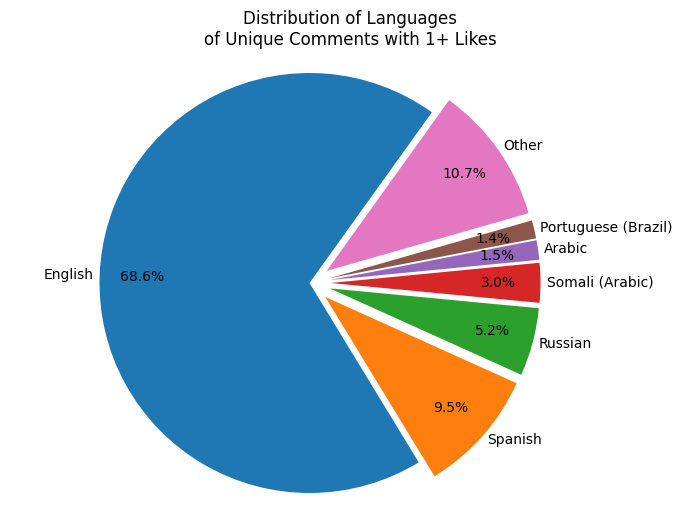

In [7]:
# Pie Chart of Distribution of Languages of Unique Comments with 1 or more Likes

# Top Languages to show
language_map = {
    "en": "English",
    "es": "Spanish",
    "ru": "Russian",
    "so": "Somali (Arabic)",
    "ar": "Arabic",
    "pt": "Portuguese (Brazil)",
}

# Get the count per language. Combine less common languages into "Other"
# Note:
#   This is the count of unique comments with 1+ likes
#   We already removed duplicate texts and comments wtih 0 likes
language_counts = translated_comments['Language'].replace(language_map).value_counts()
top_languages = language_counts.nlargest(len(language_map))
other_count = language_counts.iloc[len(language_map):].sum()
top_languages['Other'] = other_count

fig, ax = plt.subplots(figsize=(8, 6))
explode = [0] + [0.1]*len(language_map)
top_languages.plot.pie(
    ax=ax,
    startangle=54.36,
    explode=explode,
    labeldistance=1.03,
    autopct="%.1f%%",
    pctdistance=0.80
)
ax.set_ylabel('')
fig.suptitle("Distribution of Languages\nof Unique Comments with 1+ Likes", x=0.55, y=0.95)
ax.axis('equal')
plt.show()

#### Pie Chart of Total Likes per Language
* We can view the distribution of likes for each language
    * Even with all the previous filtering, the likes per language will be preserved
* ~97% of all likes are on English comments
    * This isn't totally surprising since the primary language of the video is English
    * This means that even if translation from other languages to English aren't perfect, it is a small amount of the mass anyway
    * This could mean that the "wonky" translationg are a larger problem than just using the raw text, even if it is another language
        * A "wonky" translation is when an English comment get labeled as some other language then is incorrected translated to English. Ex:
            * Original: &emsp;*Maaacck!!...MUAAAACCK* !! - Arnold Schwarzenegger (Tahitian detected)
            * Translated: *Maaacck!! ... MUAAAACCK* - Arnold Arnold Arnold
* The language with the 2nd most likes was Spanish with 1.1%
* The language with the 3rd most likes was Russian with 0.5%
    * Adding Russian to the chart begins to make it unreadable

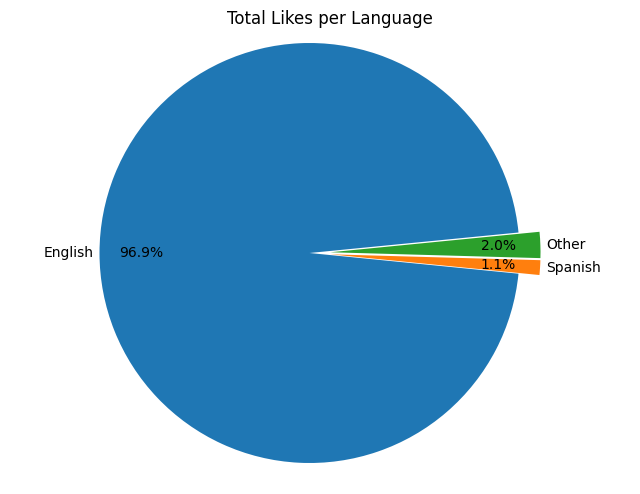

In [8]:
# Pie Chart of Total Likes per Language
language_map = {
    "en": "English",
    "es": "Spanish",
}

# Get the count of likes per language. Combine less common languages into "Other"
# Note:
#   We preserved likes when removing duplicate texts and only removed comments with 0 likes
#   So the count of likes per language is the same here as it would be before any data filtering
likes_per_language = translated_comments.groupby('Language')['Likes'].sum()
likes_per_language = likes_per_language.sort_values(ascending=False)
likes_per_language = likes_per_language.rename(index=language_map)
top_likes = likes_per_language.nlargest(len(language_map))
other_likes = likes_per_language.iloc[len(language_map):].sum()
top_likes['Other'] = other_likes

# Plot the pie chart
fig, ax = plt.subplots(figsize=(8, 6))
explode = [0] + [0.1]*len(language_map)
top_likes.plot.pie(
    ax=ax,
    startangle=5.6,
    labeldistance=1.03,
    explode=explode,
    autopct="%.1f%%",
    pctdistance=0.80
)
ax.set_ylabel('')
fig.suptitle("Total Likes per Language", x=0.525, y=0.90)
ax.axis('equal')
plt.show()

#### Histogram of Tokenized Lengths
* We can view the distribution of text lengths based on word count, character count, and tokenized length
* Most comments are shorter than 20 words. Most are less than 111 characters. Most are less than 29 tokens

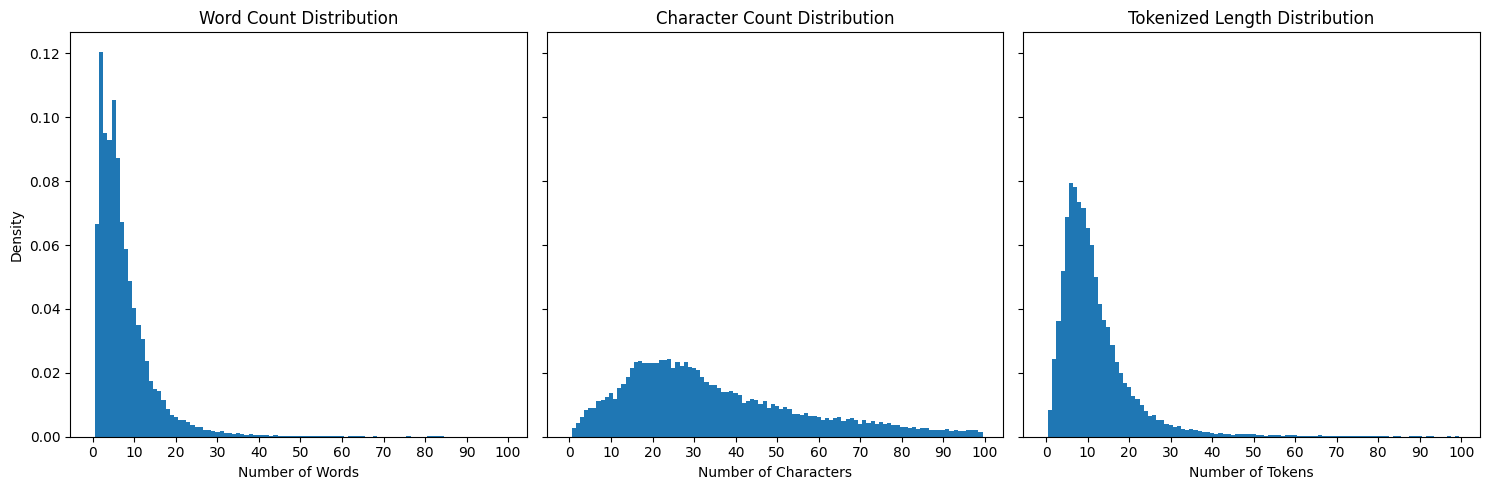

95% of comments have less than 20.0 words
95% of comments have less than 111.0 characters
95% of comments have less than 29.0 tokens


In [9]:
# Histograms of Lengths

# Calculate text statistics
word_counts = final_comments["English Text"].apply(lambda x: len(x.split()))
char_counts = final_comments["English Text"].apply(len)
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_ID)
token_lengths = [len(tokenizer.encode(comment)) for comment in final_comments["English Text"]]

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
num_bins = 101
tick_step = 10

# Word Count Histogram
axes[0].hist(word_counts, bins=np.arange(num_bins) - 0.5, density=True)
axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Density")
axes[0].set_xticks(np.arange(0, num_bins + 1, tick_step))

# Character Count Histogram
axes[1].hist(char_counts, bins=np.arange(num_bins) - 0.5, density=True)
axes[1].set_title("Character Count Distribution")
axes[1].set_xlabel("Number of Characters")
axes[1].set_xticks(np.arange(0, num_bins + 1, tick_step))

# Tokenized Length Histogram
axes[2].hist(token_lengths, bins=np.arange(num_bins) - 0.5, density=True)
axes[2].set_title("Tokenized Length Distribution")
axes[2].set_xlabel("Number of Tokens")
axes[2].set_xticks(np.arange(0, num_bins + 1, tick_step))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

print(f"95% of comments have less than {np.percentile(word_counts, 95)} words")
print(f"95% of comments have less than {np.percentile(char_counts, 95)} characters")
print(f"95% of comments have less than {np.percentile(token_lengths, 95)} tokens")

#### Histogram of Number of Likes
* There are ~1.1M likes between all 33k comments.
* Looking at the histogram, we see most of the comments have only a few likes
    * The most liked 100 comments are omitted from the histogram to make it more readable
    * The comment with the most likes is Mr Beast's pinned comment with ~114k likes
        * There are only 10 comments with more than 10k likes. These 10 comments have ~330k likes total (31% of all comment likes)
        * There are only 25 comments with more than 5k likes. These 25 comments have ~430k likes total (40% of all comment likes)
        * There are only 100 comments with more than 1600 likes. These 100 comments have ~630k likes total (59% of all comment likes)
* Note: We removed all comments with 0 likes
* Note: We combined 2 comments if they had identical texts
    * 2 comments with 15 likes would appear on the histogram as 1 comment with 30 likes

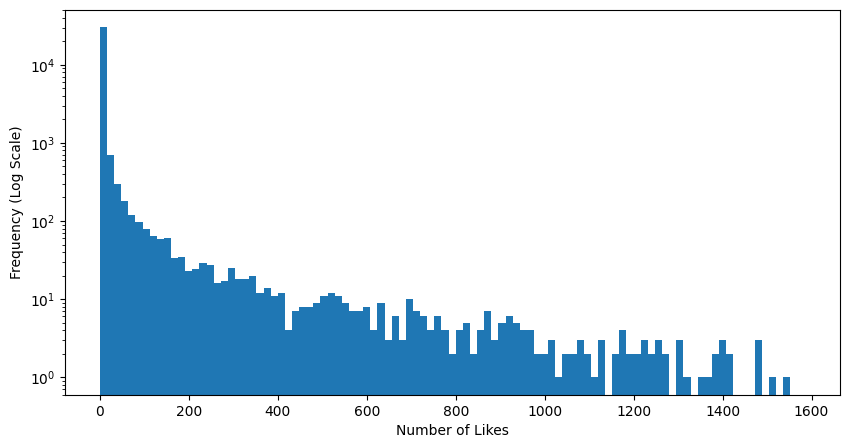

In [10]:
# Histogram of Number of likes
plt.figure(figsize=(10, 5))
plt.hist(final_comments["Likes"], bins=np.arange(0, 1600, 16), log=True)
plt.xlabel("Number of Likes")
plt.ylabel("Frequency (Log Scale)")
plt.show()

#### Cumulative Distribution of Likes
* An alternative to the histogram of number of likes is the cumulative distribution of likes
* Looking at the cumulative sum of likes vs numbner of top comments
    * The top 1 comment has ~11% of all comment likes
    * The top 1% of comments have 77% of all comment likes
    * The top 2% of comments have 86% of all comment likes
    * The top 5% of comments have 93% of all comment likes
    * The top 10% of comments have 96% of all comment likes
* Note: We removed all comments with 0 likes
* Note: We combined 2 comments if they had identical texts
    * 2 comments with 15 likes would appear on the histogram as 1 comment with 30 likes

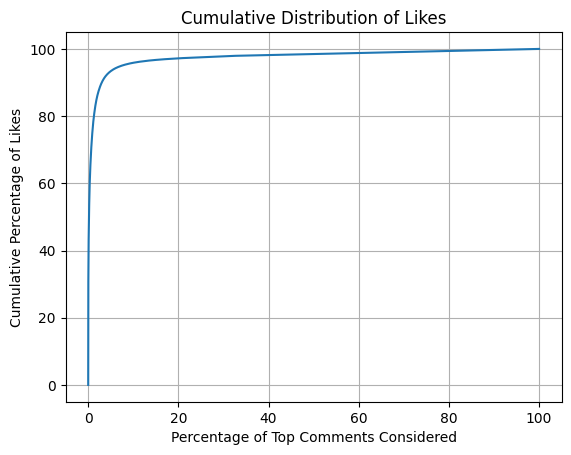

In [11]:
# Cumulative Distribution of Likes
sorted_likes = final_comments["Likes"].sort_values(ascending=False).to_numpy()
cumulative_likes = np.cumsum(sorted_likes) / sum(sorted_likes)
cumulative_likes = np.insert(cumulative_likes, 0, 0.0) * 100

plt.plot(np.linspace(0, 100, len(cumulative_likes), endpoint=True), cumulative_likes)
plt.grid()
plt.xlabel("Percentage of Top Comments Considered")
plt.ylabel("Cumulative Percentage of Likes")
plt.title("Cumulative Distribution of Likes")
plt.show()

### Embedding
* In order to find common topics, we need to convert the raw text into embeddings
    * An embedding is just a vector. The goal is that the vector captures semantic similarities so comments with similar meanings are close together even if the actual words used are very different
* To get an embedding, we use an embedding model
    * It is just a model that takes in text (or tokenized text) and outputs an embedding
    * This model is not trained on our data, but we hope the data it was trained on is similar enough that it will  group similar comments near each other
* Researchers at Hugging Face published a set of benchmark tasks for embedding models, "MTEB: Massive Text Embedding Benchmark"
    * There are just over 100 tasks divided between a number of tasks
* MTEB has a clustering task, and has several datasets for clustering
    * Unfortunately, the only "web domain" data is from Stack Exchange which is not exactly apples-to-apples with our data but is likely close enough
    * There is other data from the internet, but sources like Wikipedia or simlar are considered encyclopaedic, non-fiction, or similar. Wikipedia and such datasets would not be similar to YouTube comments. Stack Exchange is the only "web" data.
* Hugging Face has a leaderboards of all model submissions and allows us to rank by certain tasks and datasets
    * The top 2 performing models on the clustering task with Stack Exchange data (as of the time of writing this) are gte_Qwen1.5-7B-instruct and gte-Qwen2-7B-instruct with scores of 80.60 and 80.26 respectively
    * The scores are likely close enough that the Stack Exchange Clustering alone could not definitively tell us which model would be better on our dataset of YouTube comments
    * Given that, I have chosen to use the Qwen2 model as it generally has better performance than the Qwen1.5 model
* Note: The embeddings are normalized by the Qwen2 model to have length 1

In [12]:
if os.path.exists(EMBEDDINGS_PATH):
    embeddings = np.load(EMBEDDINGS_PATH)
else:
    model = SentenceTransformer(EMBEDDING_MODEL_ID, trust_remote_code=True)
    model.max_seq_length = EMBEDDING_MAX_LENGTH
    embeddings = model.encode(final_comments["English Text"].tolist(), batch_size=1, show_progress_bar=True)
    np.save(EMBEDDINGS_PATH, embeddings)
    del model

### Dimensionality Reduction
* Clustering algorithms, and especially density based clustering algorithms, generally don't work well is very high dimensional spaces
    * The embedding model outputs a 3584 dimensional vector for each comment
* PCA is a linear method for dimensionality reduction
    * We won't actually be using PCA for dimensionality reduction, but PCA can give us some insight into the trade-off of dimensionality reduction vs information loss
        * Explained variance approximates "information loss" in this case
    * The cumulative distribution of explained variance vs number of dimensions shows us that the first few dimensions can explain most of the variance
        * A 36 dimensional represenation of the original embeddings has 1% the number of dimensions but can explain 55% of variance
    * We can preserve 80% of the explained variance with 217 dimensions
        * For 90%, we would need to jump all the way up to 538 dimensions
* UMAP is a non-linear method for dimensionality reduction that claims to preserve both local and global structures in the data
    * UMAP is often used for clustering because it has nice properties when given complex data
        * Generally preserves local structure and projects similar points near each other
        * Generally preserves global structure, so different clusters are well seperated
        * Can have noise reducing properties
    * UMAP isn't perfect, and there are valid critisims of it
    * UMAP will be used as the dimensionality reduction method for this demo
* UMAP requires n_neighbors, n_components, and min_dist as parameters
    * n_neighbors determines the balance between local vs global features
        * This analysis is looking for broad, main themes
        * I use a value of 30 which should balance both local and global structure, but possbily leaning more towards global structure
    * n_components is the dimensional space of after reduction
        * I use 217 which is an informed guess from PCA
    * min_dist is the closest distance that points can be packed together in the new space
        * Since we want high density clusters, we set min_dist to 0.0 to allow UMAP to pack the points tightly
* Since we are still using a relatively high dimensional space, I use the cosine metric instead of Euclidean or others

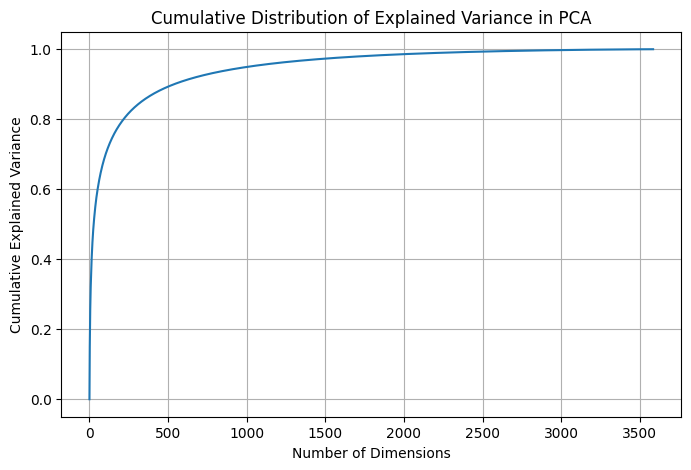

In [13]:
# Compute cumulative explained variance from PCA
pca = PCA()
pca.fit(embeddings)
explained_variance_first = np.cumsum(pca.explained_variance_ratio_)
explained_variance_first = np.insert(explained_variance_first, 0, 0.0)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(0, len(explained_variance_first)), explained_variance_first)
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Distribution of Explained Variance in PCA")
plt.grid()
plt.show()

In [14]:
# Hyperparameter - Choose the minimum number of dimensions that explains 80% of the variance
EXPLAINED_VARIANCE_FIRST = 0.8
n_components_first = np.argmax(explained_variance_first >= EXPLAINED_VARIANCE_FIRST)

# Hyperparameter - Min Samples is twice the number of dimensions
MIN_SAMPLES_FIRST = 2 * n_components_first

In [15]:
# We want the number of dimensions that explains 80% of the explained variance (217 dims)
# min_dist is 0.0 so get points clustered as closely together as possible
# n_neighbors of 30 balances local and global structures
# 217 is still a high dimensional embedding, so we use cosine for our metric
# use a random state for repeatability, and n_jobs=1 because the UMAP parallelism doesn't work when seeded
umap_model = UMAP(
    n_components=n_components_first,
    min_dist=0.0,
    n_neighbors=30,
    metric='cosine',
    random_state=42,
    n_jobs=1 # UMAP does not allow parallelism when seeded
)
dim_reduced_embeddings = umap_model.fit_transform(embeddings)

/home/ncalifan/miniconda3/envs/ml_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Clustering
* We will use DBSCAN for clustering to find regions with high density
* DBSCAN has two parameters: eps and min_samples
    * To determine eps, I use the Kneedle Method (Finding a "Kneedle in a Haystack: Detecting Knee Points in System Behavior)
        * The Kneedle Method is uses the idea that we can get a gauge on the value of eps by looking at the distance between points in our embedding space
        * Each "distance" is the distance from one point to its K-th nearest neighbor
            * K can be taken to be value used for min_samples (2 * dimensionality of embedding)
        * We can sort the distances and plot them with the x-value being the sorted index and the y-value being the distance
        * There should be an "elbow" or a "knee" in the plot
            * This method is a subset of "Elbow Methods"
        * Kneedle Algorithm
            * The Kneedle method begins by plotting the line from the start of the curve to the end
            * The knee is then the point on the curve that is farthest from that line
        * This is obvisouly not going to be optimal in any way, but we have to make some kind of educated guess
    * For min_samples, it is often useful to use domain knowledge to 

In [16]:
def calculate_intra_cluster_variance(cluster_embeddings):
    """ Calculates the intra-cluster variance for a given cluster """
    centroid = np.mean(cluster_embeddings, axis=0)
    variance = np.sum((cluster_embeddings - centroid) ** 2)
    return variance / len(cluster_embeddings)

In [17]:
# Kneedle Method
def kneedle(n_neighbors, embeddings, plot=False):
    # For each point, get the distance to its K-th nearet neighbor
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine").fit(embeddings)
    distances, __ = nbrs.kneighbors(embeddings)
    dist_sorted = sorted(distances[:, distances.shape[1] - 1], reverse=True)

    # Consider the distances curve
    # Find the distance from the distances curve to the straight line that connects the start and end of that curve
    #   This is the difference curve
    endpoint_line = np.linspace(dist_sorted[0], 0, len(distances), endpoint=True)
    dist_difference = endpoint_line - dist_sorted

    # Find the maximum of the difference curve. That point is the elbow/knee
    max_difference_idx = np.argmax(dist_difference)

    # Plot the distances curve and the difference curve
    plt.plot(dist_sorted, label="K-NN Distance")
    plt.plot(dist_difference, label="Difference")
    plt.scatter(max_difference_idx, dist_sorted[max_difference_idx])
    plt.scatter(max_difference_idx, dist_difference[max_difference_idx])
    plt.legend()
    plt.show()

    # Elbow is the max difference
    return dist_sorted[max_difference_idx]

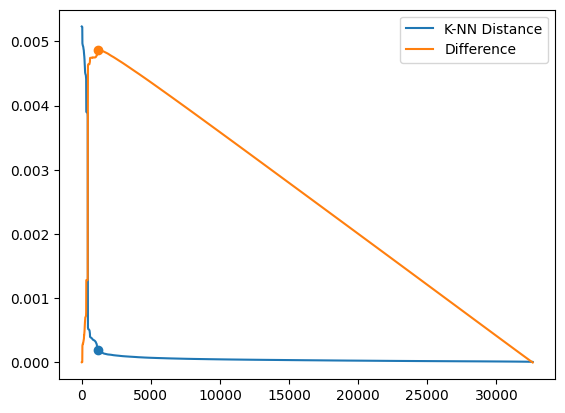

In [18]:
elbow_dist = kneedle(MIN_SAMPLES_FIRST, dim_reduced_embeddings, plot=True)
clusterer = DBSCAN(
    eps=elbow_dist,
    min_samples=MIN_SAMPLES_FIRST,
    metric="cosine"
)

clustering = clusterer.fit(
    dim_reduced_embeddings,
    sample_weight=final_comments["Likes"]
)

In [19]:
# Create a DataFrame that includes the clustering information
clustered_comments = final_comments.copy()
clustered_comments["First Cluster"] = clustering.labels_

### Results of First Clustering

The first pass at clustering allows us to find several meaningful clusters, and will let us remove ~8k of the ~33k points when we do a second pass. Hopefully those ~8k were acting as "noise" and when we clustering just the remaining samples it results in more meaningful topics

Unforunately, most of the comments get grouped into clusters 0 and 1 (cluster 8 seems to be in a similar situation but is seperate and much smaller). The other clusters are well segmented and have low intra-cluster variance, which can easily be confirmed by checking samples from clusters 2 - 7.

For clusters 2-7, we don't need TF-IDF to do topic modeling for each cluster because the comments within a cluster are incredibly simple and nearly identical.

Cluster 0 & 1: Huge and diverse
* Based on a reading a sample of comments in each of these clusters, each of these have many topics inside them
    * This is evident by the top comments, but was confirmed by skimming more comments

Clusters 2, 3 & 6: Mythpat Bhai
* ~42k likes
* These 3 clusters all relate to "Mythpath Bhai". They often have give the same phrase then have exclaimation points and/or emojis
    * Cluster 2 is "Mythpat Bhai"
    * Cluster 3 is "Mythpath Bhai x Mr Beast"
    * Cluster 6 is "Mission Mythpat Bhai"
* From what I can gather, Mythpath Bhai is name of another YouTuber and he voiced the Hindi dub of the video
* I would speak to our stakeholders to confirm this and mention that comments referencing him have a total of ~33k Likes

Cluster 4: Comments generally refer say "Give him another chance"
* ~52k Likes

Cluster 5: Fede Vigevani
* ~7k Likes
* This cluser refers to Fede Vigevani's dub of the video. Similar to the Mythpat Bhai
* Also includes more generic references to other dubbings
* Also includes several mentions of Klingon - Fede's dubbing of the video is labeled "Klingon"
    * Some quick research showed this is not the first time it's been labeled Klingon, so that would be something to bring up as well

Cluster 7: Same text repeated 9 times (with a collective ~3.6k likes). Text:<br />
&emsp;M - Mighty in perseverance<br />
&emsp;A - Always fearless<br />
&emsp;C - Courageous and relentless<br />
&emsp;K - Keep pushing forward<br />
* ~4k likes

Cluster 8: Generally about Mack, hard to immediately see any overarching topic

Noise: Most comments are related to Khatron Ke Khiladi which seems to be an Indian version of Fear Factor. There are also several more "Mythpat" comments

In [20]:
cluster_labels = [idx for idx in clustered_comments["First Cluster"].unique() if idx != -1]

NUM_TOP_LIKED_SHOW = 5
for cluster_label in cluster_labels:
    # Get indices of points in the current cluster
    cluster_idxs = np.where(clustered_comments["First Cluster"] == cluster_label)[0]
    
    # Get the subset of the DataFrame for the cluster
    cluster_df = clustered_comments.iloc[cluster_idxs]
    
    # Select the most liked comments in the cluster
    top_liked = cluster_df.nlargest(NUM_TOP_LIKED_SHOW, "Likes")

    intra_cluster_variance = calculate_intra_cluster_variance(dim_reduced_embeddings[cluster_idxs])

    print(f"Cluster {cluster_label}: {len(cluster_idxs)} comments | {sum(cluster_df["Likes"])} likes | {np.round(intra_cluster_variance, 2):.2f} intra-cluster variance")

    # Print the most liked comments
    for _, row in top_liked.iterrows():
        print(f"- ({row['Likes']} likes) {row['English Text']}".replace("\r", "").replace("\n", " "))
    print()

# Print the number of noise points
noise_count = (clustered_comments["First Cluster"] == -1).sum()
print(f"Number of Noise Points: {noise_count}")

Cluster 0: 18939 comments | 539673 likes | 7.57 intra-cluster variance
- (114454 likes) The new Feastables bars will take some time to hit shelves! Should be in every Walmart right now and give the other retailers some time to get the new product ❤
- (24582 likes) This is the saddest thing I've seen this month.  Give this man another chance
- (18022 likes) Bro was tortured and then went home with nothing An Absolute legend
- (16041 likes) The way he did the sinking car challenge alone deserves 800k
- (15373 likes) We need this guy back. It's too heartbreaking watching him preserve and still end up empty handed.

Cluster 1: 5365 comments | 420993 likes | 1.22 intra-cluster variance
- (81519 likes) Mack's determination and resilience are truly inspiring. He deserves all the success that comes his way.
- (24062 likes) Mack has every right to become a villain.
- (14480 likes) Lets give Mack a 3rd chance hes deserves it
- (8415 likes) We need another episode to complete the Mack trilogy, fo

### Second Clustering

For the next pass of clustering, I ignore samples that are well clustered based on the first pass of clustering. I.e. the samples in clusters 2 through 7.

I perform a similar dimensionality reduction, but only using only the samples of interest so the mappings are better tuned to the remaining samples.

I found that DBSCAN did not perform well on this subset of the data. While tuning the parameters it tended to do one of the following: label everything noise, label a substantial proportion noise and create 1-2 large clusters, or label nothing noise and create 1-2 large clusters. I performed hyperparameter tuning on UMAP's n_components and n_neighbors as well as DBSCAN's eps and min_samples. There were a small subset of hyperparameters that would have ~6 clusters. But the clusters didn't seem to be particularly meaningful. This may be because the first round of clustering got all the high density clusters, and DBSCAN looks for high density volumes to seed clusters.

After DBSCAN didn't work, I turned to K-means clustering. Sklearn's implementation of K-means doesn't support weighted samples, so I just repeated samples based on the number of likes. I found that the raw number of likes was not great for this. Using the number of likes to be the sample weighted didn't work well. The top 10 comments have almost a 3rd of the total likes, so if we use the number of likes as the sample weighting, then the top N comments essentially become the centers for the clusters. The clusters then lose meaning because they are severely overfit on the most liked samples. To adjust this, I created a sublinear weighting function. The idea behind it is that we still want the number of likes to guide the clusters, but not directly proportionally. The sublinear function is linear from 1 to 10 (thanks to integer rounding), but then diverges more and more from a linear function. A comment with 100 likes has a weight of 62. The most liked comment has 114k likes, but only has a weight of 607.

After trying some values for clusters between 10 and 100, I found that 40 gave interpretable results. If anything, 40 is probably too many clusters. However, it felt relatively easy to identify trends in the clusters by looking at the top comments and top TF-IDF topics (discussed below). By skimming many comments from each cluster, I was able to confirm that the top comments and TF-IDF topics were representative of the entire cluster for the most part. The purpose of clustering was to find trends in the comments without having to read tens of thousands of comments. While 40 clusters is still quite a bit of work to go through, it is at least manually tractible. If we needed many more clusters (say 400 instead of 40), I would have implemented other tricks to combine clusters.

In [21]:
second_cluster_idxs = np.where(np.isin(clustered_comments["First Cluster"], [0, 1, 8]))[0]
embeddings_second_cluster = embeddings[second_cluster_idxs]
comments_second_cluster = clustered_comments.iloc[second_cluster_idxs]

In [22]:
# Dimensionality Reduction

# Compute cumulative explained variance from PCA
pca = PCA()
pca.fit(embeddings_second_cluster)
explained_variance_second = np.cumsum(pca.explained_variance_ratio_)
explained_variance_second = np.insert(explained_variance_second, 0, 0.0)

# 80% of explained variance
EXPLAINED_VARIANCE_FIRST = 0.8
n_components_second = np.argmax(explained_variance_second >= EXPLAINED_VARIANCE_FIRST)

umap_model = UMAP(
    n_components=n_components_second,
    min_dist=0.0,
    n_neighbors=5,
    metric='cosine',
    random_state=42,
    n_jobs=1, # UMAP does not allow parallelism when seeded
    low_memory=True
)
dim_reduced_embeddings_second_cluster = umap_model.fit_transform(embeddings_second_cluster)

/home/ncalifan/miniconda3/envs/ml_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [23]:
def sublinear_like_weighting(likes):
    """ A sublinear function to modify the weight of likes """
    # From 1 to 10, the weight is linear (thanks to rounding)
    # From 10 to 100, the weight begins to be more nonlinear (f(100) = 62)
    # After 100, the function is highly sublinear. (f(100k) = 586)
    denom = np.power(likes+100, 0.75)
    return np.rint(33 * likes / denom).astype(int)

# For K-means clustering, we need to repeat the samples based on the number of Likes
#   We are only using the samples in clusters 0, 1 and 8 from the first round of clustering: embeddings_second_cluster
#       In practice, it is the dimensionality reduced version: dim_reduced_embeddings_second_cluster
# Create a copy of the embeddings with repeated samples: repeated_embeddings
#       In practice, it is the dimensionality reduced version: dim_reduced_repeated_embeddings
# There are N samples in first_embeddings_subset, and repeated_embeddings will have N unique values
#   To make it easy to map back to the original dataframe, repeated_embeddings[:N] = embeddings_second_cluster
indices = np.arange(len(comments_second_cluster))
sample_weights = sublinear_like_weighting(comments_second_cluster["Likes"])
repeated_indices = np.hstack([np.full(count - 1, i) for i, count in enumerate(sample_weights) if count > 1])
weighted_indices = np.concatenate([indices, repeated_indices])
dim_reduced_repeated_embeddings = dim_reduced_embeddings_second_cluster[weighted_indices]

# Perform clustering and get the labels
NUM_K_MEANS_CLUSTERS = 40 # Hyperparameter
kmeans = KMeans(n_clusters=NUM_K_MEANS_CLUSTERS, random_state=42, n_init=100)
kmeans_clustering = kmeans.fit(dim_reduced_repeated_embeddings)
clustered_comments.loc[second_cluster_idxs, "Second Cluster"] = kmeans_clustering.labels_[:len(second_cluster_idxs)]

### Topic Modeling

The topics of clusters were not always as immediately clear. We can use TF-IDF to try to find topics (which will guide our manual review of samples).

TF-IDF has two terms Term Frequency (TF) and Inverse Document Frequency (IDF).
* TF measures how often a topic appears in a comment - a topic is just an ngram in this case. I use ngrams of length 1, 2 and 3. It was uncommon for topics with 4+ words to score highly. Since the comments are so short, I use binary TF which just means 0/1 for does this topic appear in this comment at least once.
* IDF is a normalization measure. Certain topics like "he was" are going to appear in many many comments. The IDF normalizes those topics to make the TF-IDF an importance measure.
* As an example, if you run the TF-IDF on Shakespeare's 37 plays:
    * You'll find the word "Romeo" only appears in one play, but it appears 130 times. So the word "Romeo" is both only present in a small number of documents (only 1 play), but it comes up a lot in that play. So its TF-IDF score is very high, and we would call that a topic.
    * The word "Falstaff" is in 4 plays, and in one play appears 46 times. This would have a lower, but still quite high score. It might be a less prevalent topic.
    * The word "fool" appears in 36 of the 37 plays, and in a large proportion of the plays it appears less than 10 times. Since the word "fool" appears in almost every play, it is just a word that Shakespeare likes. It is not a topic of any of those plays.

To get the topics of each cluster, we can perform the IDF step on all comments, then perform the TF step on just the current cluster. Then we can sum the TFs across the comments of the current cluster and get the TF-IDF score of this cluster normalized across all comments.

TF-IDF can have a problem with noise. To combat noise, we only consider a topic if it appears in more than 20 comments, but less than 10% of all comments (something like "he is" might appear in many comments and won't be represenative). We also don't want to consider stop words like "the", "a", "on", etc. There are some other tricks like lowercasing that are used as well. I also 

### Results

After reading the top comments and topics for each cluster, I comfirmed by skimming many comments from that cluster that the top comments and topic were representative of the cluster. I gave what I though was the most salient topic of the cluster, and grouped simlar clusters together (there were obvious groupings). Part of what made this difficult to do automatically is that there was a lot of noise, and the comments were very short. If we had many clusters or different data, I could be smarter about automatically combining clusters.

I am defining "noise" to be any comment that is generic enough that it could have been on most Mr Beast videos and still make sense. Examples:
* 20:40 Insane
* First comment!!!
* Who's watching from Africa?
* So sad! Can't believe it
* At least give him $100k
* < Quote from the video >

#### Main Topics and Associated Clusters
Variant of "Another Chance" (X Likes)
* Cluster  0 - "Mack deserved another try"
* Cluster  2 - "This guy deserved another chance"
* Cluster  3 - "Give him another chance Mr Beast"
* Cluster  4 - "Jimmy, give Mack another chance"
* Cluster  5 - "Give him another chance" in a sentence with the word "challenge"
* Cluster 12 - "PLEASE give mack one more try. He’s so determined it’s inspiring"
* Cluster 13 - "Give Mac another chance"
* Cluster 15 - "Give him another chance, the underwater challenge was crazy"
* Cluster 16 - "One more chance"
* Cluster 17 - "Bring Mack back"
* Cluster 19 - "Give him another chance"
* Cluster 21 - "Bring him back"
* Cluster 29 - "Give Mack another chance"
* Cluster 31 - "Give this man another chance"

All about Mack (X Likes)
* Cluster  6 - "Mack should join the Mr Beast crew"
* Cluster 10 - "Mack is the best contestant"
* Cluster 22 - "Justice for Mack"
* Cluster 23 - "Mack deserves the money"
* Cluster 25 - "Mack is about to become a villian"

Challenges (X Likes)
(The video was composed of several challenges that Mack had to complete to win, the last of which involved cookies)
* Cluster 14 - Cookie Challenge
* Cluster 38 - Challenges: "Squid Game" and "Faced Fear"
* Cluster 39 - Cookie Challenge
* Note: Cluster 15 could also go here

Mr Beast's Advertisements ~116k Likes
* Cluster 27 - Feastables/Chocolate

Other People (X Likes)
* Cluster  8 - Chandler's Reaction
* Cluster 28 - Faith's Voice (referring to a person, not sure who this is) # TODO: rewatch and see if this is a member of Mr Beast's crew

Noise (X Likes)
* Cluster  1 - Timestamps
* Cluster  7 - Country Related ("Greetings from Peru")
* Cluster  9 - Seemingly unrelated comments
* Cluster 11 - All about money (the prize was $800k)
* Cluster 18 - "Fear"
* Cluster 20 - Seemingly unrelated comments
* Cluster 24 - 15 comments of "Matt stop breaking my set" (noise because it is just a quote from the video)
* Cluster 26 - 8 total comments of "Bro's dad lore is gonna be insane"
* Cluster 30 - Emojis and/or Yesssss/Noooooo
* Cluster 32 - Seemingly unrelated comments
* Cluster 33 - 1 comment: "Who is Hindu?"
* Cluster 34 - Palestine
* Cluster 35 - So sad
* Cluster 36 - "Anyone in _" (Blank is November, December, etc)
* Cluster 37 - Seemingly unrelated comments

In [24]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=0.10,
    min_df=20,
    ngram_range=(1, 3),
    binary=True,
    stop_words='english',
    strip_accents="unicode",
    lowercase=True,

)

# Fit the idf step on the entire document corpus
vectorizer.fit(clustered_comments["English Text"].tolist())
feature_names = vectorizer.get_feature_names_out()

In [31]:
cluster_labels = [idx for idx in clustered_comments["Second Cluster"].unique() if idx != -1 and not np.isnan(idx)]
cluster_labels.sort()

cluster_centers = kmeans.cluster_centers_
comments_second_clustering = clustered_comments.iloc[second_cluster_idxs]

NUM_TOP_LIKED_SHOW = 5
NUM_CENTROID_SHOW = 5
for cluster_label in np.sort(comments_second_clustering["Second Cluster"].unique()):
    # Get indices of points in the current cluster
    cluster_mask = comments_second_clustering["Second Cluster"] == cluster_label
    cluster_idxs = np.where(cluster_mask)[0]
    cluster_embeddings = dim_reduced_embeddings_second_cluster[cluster_idxs]

    # Get the subset of the DataFrame for the cluster
    cluster_df = comments_second_clustering.iloc[cluster_idxs]

    intra_cluster_variance = calculate_intra_cluster_variance(cluster_embeddings)
    print(f"Cluster {int(cluster_label)}: {len(cluster_idxs)} comments | {sum(cluster_df['Likes'])} likes | {np.round(intra_cluster_variance, 2):.2f} intra-cluster variance")

    # Print the most liked comments
    print("Top Comments")
    top_liked = cluster_df.nlargest(NUM_TOP_LIKED_SHOW, "Likes")
    for _, row in top_liked.iterrows():
        print(f"\t- ({row['Likes']} likes) {row['English Text']}".replace("\r", "").replace("\n", " "))

    # Get the comments closest to the cluster centroid
    print("Centroid Comments")
    cluster_center = cluster_centers[int(cluster_label)]
    cluster_distances = np.sum(cluster_embeddings * cluster_center, axis=1)  # Efficient cosine similarity
    closest_idx = cluster_idxs[np.argpartition(cluster_distances, -min(len(cluster_distances), NUM_CENTROID_SHOW))[-NUM_CENTROID_SHOW:]]
    centroid_comments = comments_second_clustering.iloc[closest_idx]
    for _, row in centroid_comments.iterrows():
        print(f"\t- {row['English Text']}".replace("\r", "").replace("\n", " "))

    # Compute TF-IDF for this cluster
    print("Top Topics")
    cluster_tfidf = vectorizer.transform(cluster_df["English Text"].tolist())
    cluster_tfidf = np.asarray(cluster_tfidf.sum(axis=0)).flatten()
    cluster_tfidf_df = pd.DataFrame({"Score": cluster_tfidf, "Topic": feature_names})
    cluster_tfidf_df = cluster_tfidf_df[cluster_tfidf_df["Score"] > 0]
    cluster_tfidf_df = cluster_tfidf_df.sort_values("Score", ascending=False)
    cluster_tfidf_df_subset = cluster_tfidf_df[cluster_tfidf_df["Topic"].str.split().str.len() > 1]
    max_width = cluster_tfidf_df["Topic"].head(5).str.len().max()
    if len(cluster_tfidf_df_subset["Topic"]):
        print("\n".join(f"\t{i+1}. {topic}" for i, topic in enumerate(cluster_tfidf_df_subset["Topic"].str.ljust(max_width).head(5))))
    else:
        print("\tNo Topics")
    print()


Cluster 0: 961 comments | 76393 likes | 0.31 intra-cluster variance
Top Comments
	- (4569 likes) Mack is a true warrior. Give this man another chance.
	- (3112 likes) mack was CRAZY for doing this. give him another Chance, he deserves it!
	- (2998 likes) Mack was seriously CRAZY for doing this, but give him another chance because it was really good. FEDE'S VOICE REALLY GAVE A LOT OF SUSPENSE! He was fabulous.
	- (2526 likes) Mack is truly a hero he deserves another chance
	- (2270 likes) Mack deserved better. Give him another chance 😭
Centroid Comments
	- Mack literally needs another try
	- Mack needs an another try
	- Mack needs another try
	- Mack tries again
	- Mack will get it on the third try
Top Topics
	1. mack chance    
	2. mack deserves  
	3. deserves chance
	4. chance deserves
	5. mack chance deserves

Cluster 1: 668 comments | 16527 likes | 1.08 intra-cluster variance
Top Comments
	- (3489 likes) My heart stayed on 20:40
	- (1601 likes) 20:40 that camera shot was absolutely 

### Final Breakdown of engagement based on clusters

We use likes as an approximation of viewer engagement. More likes means that topic is more engaged with

In [32]:
# Add a column with the categorizations
categorizations = {
    "Another Chance": np.isin(clustered_comments["Second Cluster"], [0, 2, 3, 4, 5, 12, 13, 15, 16, 17, 19, 21, 29, 31]) | np.isin(clustered_comments["First Cluster"], [4]),
    "All About Mack": np.isin(clustered_comments["Second Cluster"], [6, 10, 22, 23, 25]) | np.isin(clustered_comments["First Cluster"], [7]),
    "Challenges": np.isin(clustered_comments["Second Cluster"], [14, 38, 39]),
    "Feastables": np.isin(clustered_comments["Second Cluster"], [27]),
    "Other People": np.isin(clustered_comments["Second Cluster"], [8, 28]),
    "Noise": np.isin(clustered_comments["Second Cluster"], [1, 7, 9, 11, 18, 20, 24, 26, 30, 32, 33, 34, 35, 36, 37]) | np.isin(clustered_comments["First Cluster"], [-1]),
    "Mythpat Bhai": np.isin(clustered_comments["First Cluster"], [2, 3, 6]),
    "Fede Vigevani": np.isin(clustered_comments["First Cluster"], [5])
}
clustered_comments["Final Topic"] = np.select(list(categorizations.values()), list(categorizations.keys()), default="Uncategorized")

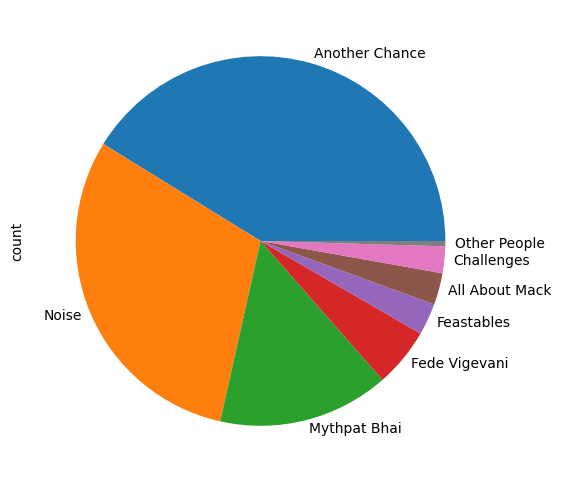

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
clustered_comments["Final Topic"].value_counts().plot.pie(
    startangle=0.0,
    labeldistance=1.05,
)
plt.show()

# TODO: query embedding on ads
Feastables
* chocolate
* Featables
* walmart

Shopify
* shopify
* shopping
* online shopping